In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

In [11]:
df_train = pd.read_csv('train.csv')
df_data = df_train.copy()
df_train.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [12]:
df_test = pd.read_csv('test.csv')
df_test.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,csid_10739,22.500174,3.702145,0.118811,0.093253,0.689237,5.786842,3.748009,7.661716,B,BA
1,csid_10740,13.225950,3.600102,0.130985,0.053575,0.142756,3.940359,3.469659,33.999679,B,AA
2,csid_10741,14.603376,5.084047,-0.004651,-0.036299,0.333709,4.254662,3.855939,33.485630,B,AA
3,csid_10742,26.149905,3.025501,0.229740,0.204591,3.768405,6.942625,2.362421,0.795372,B,BA
4,csid_10743,19.810630,5.020400,-0.011347,-0.028780,0.286841,4.585513,3.278624,15.052058,C,BA


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       10738 non-null  object 
 1   customer_visit_score              10738 non-null  float64
 2   customer_product_search_score     10696 non-null  float64
 3   customer_ctr_score                10738 non-null  float64
 4   customer_stay_score               10701 non-null  float64
 5   customer_frequency_score          10738 non-null  float64
 6   customer_product_variation_score  10692 non-null  float64
 7   customer_order_score              10672 non-null  float64
 8   customer_affinity_score           10738 non-null  float64
 9   customer_active_segment           10715 non-null  object 
 10  X1                                10701 non-null  object 
 11  customer_category                 10738 non-null  int64  
dtypes: f

In [14]:
#df_train['customer_category'] = df_train['customer_category'].astype('category')
df_train.drop('customer_id', axis=1, inplace = True)

In [15]:
df_train.describe()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_category
count,10738.000000,10696.000000,10738.000000,10701.000000,10738.000000,10692.000000,10672.000000,10738.000000,10738.000000
mean,19.060941,5.274847,0.175912,0.374230,2.376895,5.788180,3.150071,17.061836,0.120600
std,7.419609,1.882559,0.372829,1.222031,5.601911,2.531309,1.035416,18.762693,0.325677
min,0.568965,-0.161940,-0.547989,-0.462494,0.028575,2.752836,0.363338,-0.486834,0.000000
25%,13.518021,3.971587,0.010840,-0.027666,0.313610,4.193234,2.454017,4.530085,0.000000
50%,18.774109,5.218479,0.074078,0.037201,0.516830,4.842575,3.118394,12.653357,0.000000
75%,24.501719,6.520364,0.159606,0.179029,1.125380,6.286400,3.756566,23.114577,0.000000
max,47.306691,16.638243,2.679474,14.701914,52.395014,18.743836,9.090206,248.552755,1.000000


* We could observe that there are missing values in 6 columns of the dataaset.

In [16]:
df_train.isnull().sum()

customer_visit_score                 0
customer_product_search_score       42
customer_ctr_score                   0
customer_stay_score                 37
customer_frequency_score             0
customer_product_variation_score    46
customer_order_score                66
customer_affinity_score              0
customer_active_segment             23
X1                                  37
customer_category                    0
dtype: int64

* Here the percent of rows with missing values is very low.

In [17]:
df_train.isnull().mean()

customer_visit_score                0.000000
customer_product_search_score       0.003911
customer_ctr_score                  0.000000
customer_stay_score                 0.003446
customer_frequency_score            0.000000
customer_product_variation_score    0.004284
customer_order_score                0.006146
customer_affinity_score             0.000000
customer_active_segment             0.002142
X1                                  0.003446
customer_category                   0.000000
dtype: float64

* We could see that the test data too have missing values in those columns.
* So we have to handle those missing values to build robust model which predicts even in those cases.

In [18]:
df_test.isnull().sum()

customer_id                          0
customer_visit_score                 0
customer_product_search_score       29
customer_ctr_score                   0
customer_stay_score                 16
customer_frequency_score             0
customer_product_variation_score    43
customer_order_score                41
customer_affinity_score              0
customer_active_segment             12
X1                                  25
dtype: int64

* From the below plots we can see that there is no huge deviation in the percent of missing values in both class.
* So here we can consider that the values are missing at random and there is no relationship between this missing vales and other values.
* So we could impute these values with a central tendency value which is the single value representation of entire distribution or we can proceed with random value imputation.

##### Central tendency value imputation

>* It may alter the variance of the distribution and also bias the original distribution when no of rows is high.

##### Random value imputation

>* It will not affect the distribution but which may not work all the times as random value can be any value in the distribution

##### Conclusion

>* The percent of missing values with original size of dataset is very less which will not greatly bias the distribution.
>* So we can proceed with imputing continuous features with median as it is not sensitve to outliers and categorical features with mode.




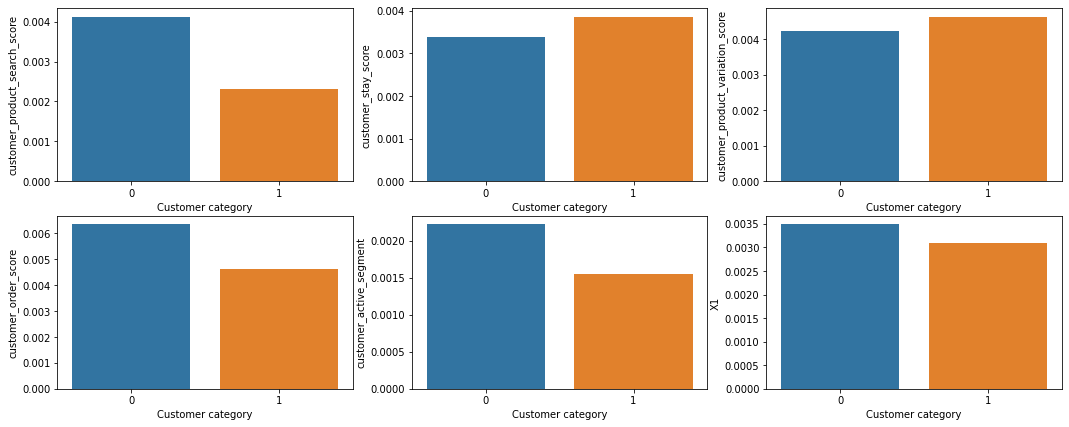

In [19]:
#Extracting the columns with NULL values
feature_with_null = [col for col in df_train.columns if col not in df_train.dropna(axis=1).columns.tolist()]
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=[18,7])
df_temp = df_train.copy()

for feature, ax in zip(feature_with_null, axes.flatten()):
    df_temp[feature+'_Null'] = np.where(df_temp[feature].isnull(), 1, 0)
    mean = df_temp.groupby('customer_category')[feature+'_Null'].mean()
    sns.barplot( x = ['0', '1'], y = [mean[0], mean[1]], ax=ax)
    ax.set_xlabel('Customer category')
    ax.set_ylabel(feature)

#print(x[1])

##### Distribution of data in classes of target variable
* We could see that the dataset is highly imbalanced as we have very few observations from class '1'.

0    0.8794
1    0.1206
Name: customer_category, dtype: float64

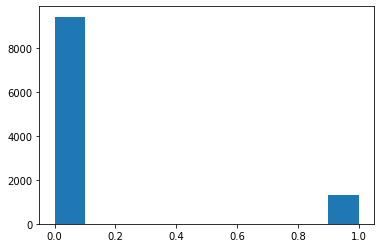

In [20]:
plt.hist(df_train['customer_category'])
df_train['customer_category'].value_counts() / df_train.shape[0]

##### Univariate analysis

* Skewness is the measure of lack of symmetry of the data in comparison with the symetrical dataset. 
* If there is unusually large value in the dataset, mean becomes greater than the median. this indicates the right skeweness of the data
* If there is unusually small value in the dataset, mean becomes lesser than the median, this indicates the left skewness of the data
* Mathemathically, 
    * If the Skewness = 0, the distribution is perfectly symmetrical.
    * If the Skewness > 0, the distribution is right skewed
    * If the Skewness < 0, the distribution is left skewed
* <a href='https://books.google.co.in/books?id=K35ZDwAAQBAJ&pg=PT270&lpg=PT270&dq=Bulmer+(1979)++rule+of+thumb&source=bl&ots=tIPrHiL92Y&sig=ACfU3U2IYsDEISHQUOF_QhF8gxfKW5mWdQ&hl=en&sa=X&ved=2ahUKEwisyMLI_fXoAhUayzgGHQVYDDMQ6AEwBHoECAwQKA#v=onepage&q=Bulmer%20(1979)%20%20rule%20of%20thumb&f=false'>Bulmer's rule of thumb </a>suggest that in real world scenerio the skewness is unlikely to be exactly zero.
    * If the Skewness < -1 or > +1, the distribution is highly skewed
    * If the Skewness is between -1 and -0.5 or +0.5 and +1, the distribution is slightly skewed
    * If the Skewness is between -0.5 and +0.5, the distribution is approximately symmetrical

###### Conclusion

* From the plot we could see that customer_visit_score, customer_product_search_score, customer_order_score are almost normally distributed.
* All other continuous features are higly skewed.

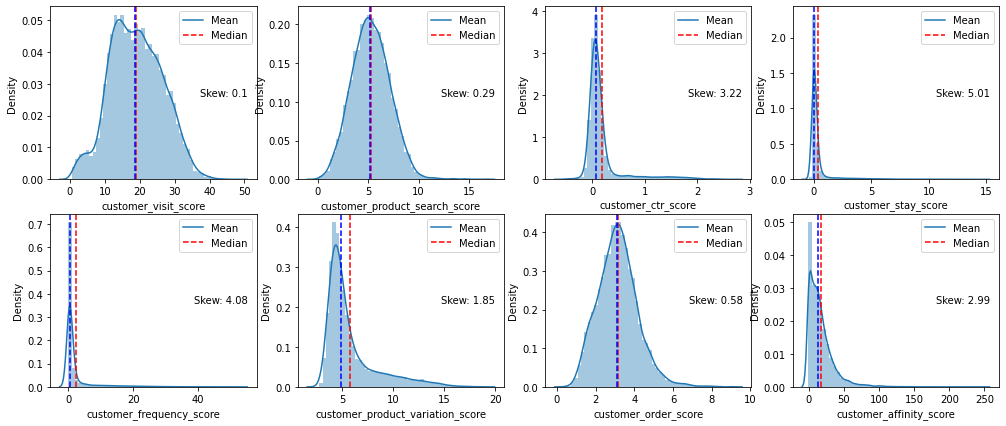

In [60]:
numeric_features = df_train.select_dtypes(include=np.number).columns.tolist()[:-1]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[17, 7])
from matplotlib.offsetbox import AnchoredText

for feature, ax in zip(numeric_features, axes.flatten()):
    sns.distplot(df_train[feature], ax=ax) 
    mean = df_train[feature].mean()
    median = df_train[feature].median()
    ax.axvline(mean, color='r', linestyle='--')
    ax.axvline(median, color='b', linestyle='--')
    #ax.text(0.5, 0.5, skew, ha='right', va='top')
    skew = np.round(df_train[feature].skew(), 2)
    skew = "Skew: "+str(skew)
    anc = AnchoredText(skew, loc="center right", frameon=False)
    ax.add_artist(anc)
    ax.legend({'Mean':mean, 'Median':median})

##### Correlation analysis between input features
* Highly correlated features will provide the same information in the prediction of the terget.
* So to build an optimal model, we could remove the multi colinear features.
* Here customer_stay_score and customer_ctr_score is highly correlated. So we could use one amoung these features for model building.

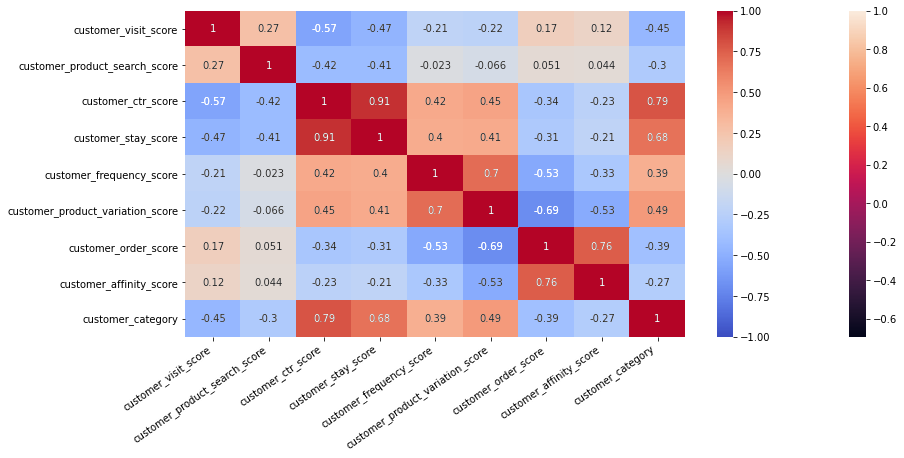

In [23]:
corr = df_train.corr()
fig, ax = plt.subplots(figsize=[14, 6])
plot = sns.heatmap(corr, annot=True)
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, center = 0, cmap="coolwarm")
ax = ax.set_xticklabels(plot.get_xticklabels(),  rotation=35, ha="right")

##### Box plot of input features
* We could observe that there is huge outliers in all the features.
* We can analyze this outliers based on each category to conclude whether to treat this outliers.

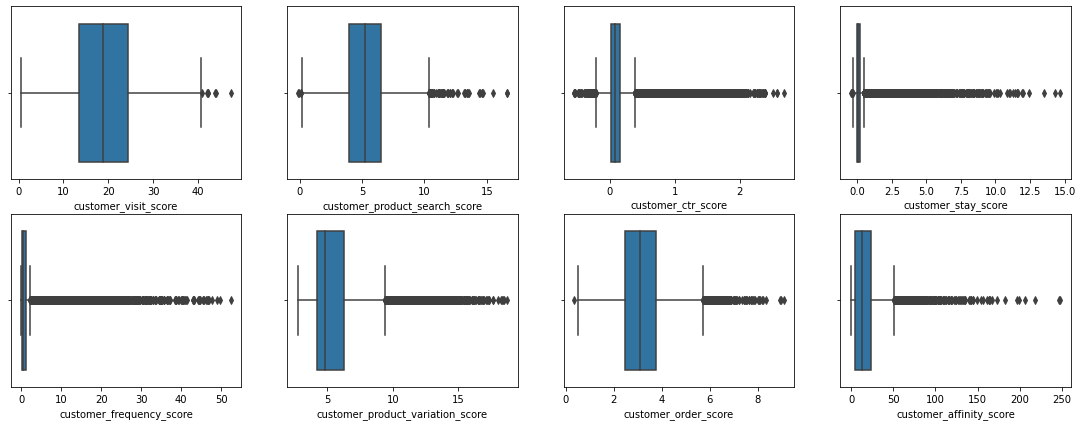

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[19, 7])
from matplotlib.offsetbox import AnchoredText

for feature, ax in zip(numeric_features, axes.flatten()):
    sns.boxplot( x=df_train[feature], ax=ax) 

##### Boxplot of input features vs the categories of target
* From the plot we could see that the outliers are not equally distributed on both the classes. 
* outliers may provide an information on the prediction of the class.
* So removing or treating the outliers may bias the information.


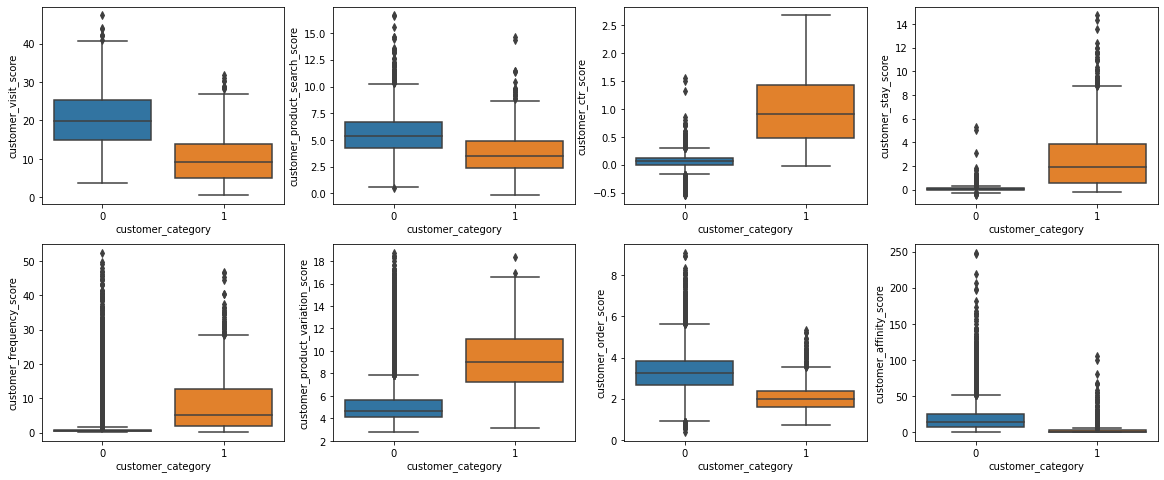

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[20, 8])
from matplotlib.offsetbox import AnchoredText

for feature, ax in zip(numeric_features, axes.flatten()):
    sns.boxplot(x='customer_category', y=feature, data=df_train, ax=ax) 

##### Boxplot of log transformed skewed input features vs the categories of target


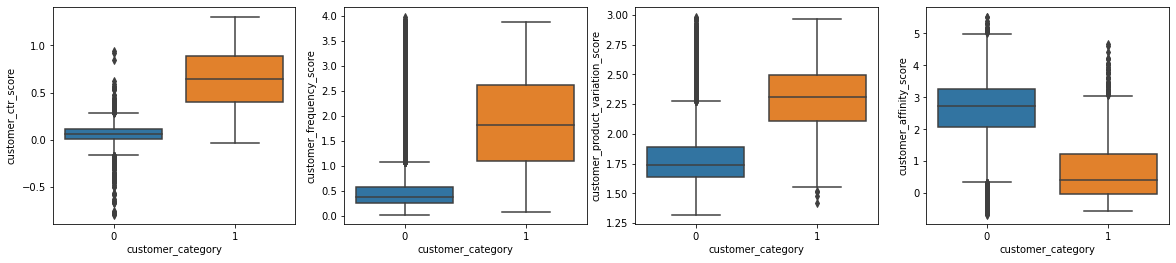

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[20, 4])
skewed_numeric_features = ['customer_ctr_score', 'customer_frequency_score', 'customer_product_variation_score', 'customer_affinity_score']
for feature, ax in zip(skewed_numeric_features, axes.flatten()):
    sns.boxplot(x=df_train['customer_category'], y=np.log1p(df_train[feature]), ax=ax) 

##### Distribution of categorical features

* Plot shows the distribution of the datapoints in each class of the category.
* We could see that certian class has very few datapoints.


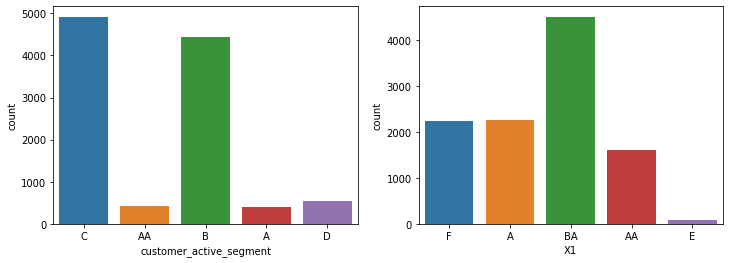

In [27]:
categorical_features = df_train.select_dtypes(include=np.object).columns.tolist()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
for feature, ax in zip(categorical_features, axes.flatten()):
  sns.countplot(x=df_train[feature], ax=ax)

customer_active_segment
AA    0.004785
A     0.004854
B     0.064108
C     0.126855
D     0.710821
Name: customer_category, dtype: float64

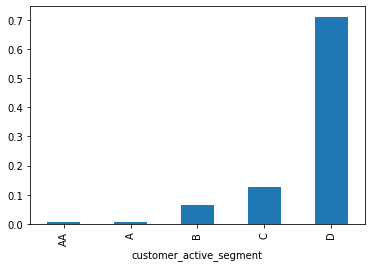

In [28]:
df_train.groupby('customer_active_segment')['customer_category'].mean().sort_values().plot.bar()
df_train.groupby('customer_active_segment')['customer_category'].mean().sort_values()

* The mean of respective classes will give more weightage to class '0'.
* So direct mean encoding will not be a good option here.
* We have to find the weighted mean of each class.

In [29]:
print("The weightage needs to be given for class 1 to make it 50% balance: ", 0.50/0.1206)
print("The weightage needs to be given for class 0 to make it 50% balance: ", 0.50/0.8794)

The weightage needs to be given for class 1 to make it 50% balance:  4.1459369817578775
The weightage needs to be given for class 0 to make it 50% balance:  0.568569479190357


Text(0.5, 1.0, 'Weighted mean of customer_category classes in customer_active_segment')

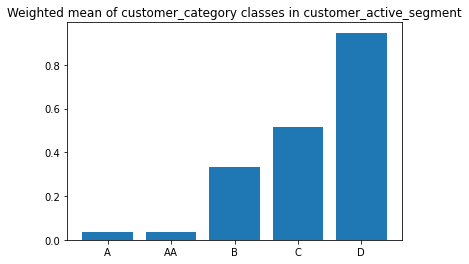

In [63]:
customer_active_segment_mean_dict = df_train.groupby(['customer_active_segment', 'customer_category'])['customer_order_score'].count()
df_customer_active_segment = pd.DataFrame(customer_active_segment_mean_dict).reset_index()
df_customer_active_segment.rename({'customer_order_score':'count'}, axis=1, inplace=True)
df_customer_active_segment.loc[df_customer_active_segment['customer_category']==0, 'count'] = 0.5685 * df_customer_active_segment.loc[df_customer_active_segment['customer_category']==0, 'count'] 
df_customer_active_segment.loc[df_customer_active_segment['customer_category']==1, 'count'] = 4.1459 * df_customer_active_segment.loc[df_customer_active_segment['customer_category']==1, 'count'] 

#print(df_customer_active_segment.groupby(['customer_active_segment']).sum()["count"].values)
#print(df_customer_active_segment[df_customer_active_segment['customer_category'] ==1][['customer_active_segment','count']])
df_customer_active_segment['mean']=df_customer_active_segment[df_customer_active_segment['customer_category'] ==1]['count']/df_customer_active_segment.groupby(['customer_active_segment']).sum()["count"].values
customer_active_segment_mean = df_customer_active_segment[df_customer_active_segment['customer_category']==1][['customer_active_segment', 'mean']].copy()
customer_active_segment_mean_final_dict = customer_active_segment_mean.set_index('customer_active_segment').to_dict()['mean']
customer_active_segment_mean_final_dict
plt.bar(customer_active_segment_mean_final_dict.keys(), customer_active_segment_mean_final_dict.values())
plt.title("Weighted mean of customer_category classes in customer_active_segment")

* Normal mean of target classes of X1 feature

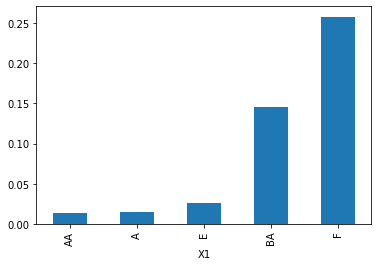

In [31]:
df_train.groupby('X1')['customer_category'].mean().sort_values().plot.bar()

In [32]:
X1_mean_dict = df_train.groupby('X1')['customer_category'].mean().to_dict()

* Weighted mean of target classes of X1 feature

Text(0.5, 1.0, 'Weighted mean of customer_category classes in X1')

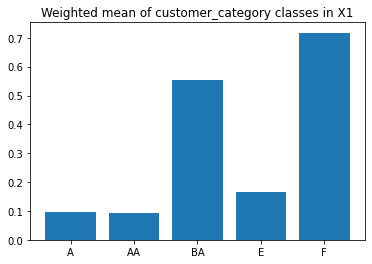

In [64]:
X1_dict = df_train.groupby(['X1', 'customer_category'])['customer_order_score'].count()
df_X1 = pd.DataFrame(X1_dict).reset_index()
df_X1.rename({'customer_order_score':'count'}, axis=1, inplace=True)
df_X1.loc[df_X1['customer_category']==0, 'count'] = 0.5685 * df_X1.loc[df_X1['customer_category']==0, 'count'] 
df_X1.loc[df_X1['customer_category']==1, 'count'] = 4.1459 * df_X1.loc[df_X1['customer_category']==1, 'count'] 

#print(df_customer_active_segment.groupby(['customer_active_segment']).sum()["count"].values)
#print(df_customer_active_segment[df_customer_active_segment['customer_category'] ==1][['customer_active_segment','count']])
df_X1['mean']=df_X1[df_X1['customer_category'] ==1]['count']/df_X1.groupby(['X1']).sum()["count"].values
X1_mean = df_X1[df_X1['customer_category']==1][['X1', 'mean']].copy()
X1_mean_final_dict = X1_mean.set_index('X1').to_dict()['mean']
X1_mean_final_dict
plt.bar(X1_mean_final_dict.keys(), X1_mean_final_dict.values())
plt.title("Weighted mean of customer_category classes in X1")

#### Pipeline

* We are using Pipeline feature available in Scikit Learn to build our model.
* Pipelines helps to bulid a better readable organized model.
* It helps to process the train, test dataset seperately which refrains the model from data leakage.
* Also it automates the preprocessing steps of test data on predictions

---

#### Planned Steps:-

##### Preprocessing

1. Dropping Features
>* Dropping customer_id and dropping customer_stay_score as it  is highly correlated with customer_ctr_score

2. Imputing Null values
>* Imputing the numeric columns customer_product_search_score, customer_product_variation_score, customer_order_score with the median.
>* Imputing the categorical columns customer_active_segment, X1 with most frequent category of the column.

2. Encoding
>* Using OneHotEncoder to encode the customer_active_segment, X1.
>* Also extracting weighted mean encoded features from the categorical features.
<br>
3. Scaling
>* Scaling with robust scaler on the skewed features.
>* Scaling with standard scaler on the normally distributed features.
<br>
##### ML Model
>* Fitting the date to machine Learning Algorithm.

In [34]:
skewed_numeric_features = ['customer_ctr_score', 'customer_frequency_score', 'customer_product_variation_score', 'customer_affinity_score']

def mean_encoding(data):
  
  imp1 = SimpleImputer(strategy='most_frequent')
  imp2 = SimpleImputer(strategy='most_frequent')
  data['customer_active_segment_mean_encoded'] = imp1.fit_transform(np.array(data['customer_active_segment']).reshape(-1,1))
  data['X1_mean_encoded'] = imp2.fit_transform(np.array(data['X1']).reshape(-1,1))
  data['customer_active_segment_mean_encoded'] = data['customer_active_segment_mean_encoded'].map(customer_active_segment_mean_final_dict)
  data['X1_mean_encoded'] = data['X1_mean_encoded'].map(X1_mean_final_dict)
  return data[['customer_active_segment_mean_encoded', 'X1_mean_encoded']]

In [35]:


gaussian_numeric_features = ['customer_visit_score', 'customer_product_search_score', 'customer_order_score']
categorical_features = ['customer_active_segment', 'X1']

gaussian_numeric_imputed = ColumnTransformer([('gaussian_numeric_features', SimpleImputer(strategy='median'), gaussian_numeric_features)]
                                   )
gaussian_numeric_imputed_scaled = make_pipeline(gaussian_numeric_imputed, StandardScaler())

skewed_numeric_imputed = ColumnTransformer([('skewed_numeric_imputed', SimpleImputer(strategy='median'), skewed_numeric_features)]
                                   )
skewed_numeric_imputed_scaled = make_pipeline(skewed_numeric_imputed , RobustScaler()) # FunctionTransformer(log_transform))

categorical_imputed = ColumnTransformer([('categorical_imputed', SimpleImputer(strategy='most_frequent'), categorical_features)]
                                   )
categorical_imputed_encoded = make_pipeline(categorical_imputed, OneHotEncoder(sparse=False, handle_unknown='ignore'))

mean_encoded = ColumnTransformer([('categorical_imputed', FunctionTransformer(mean_encoding), categorical_features)]
                                   )

final_features = FeatureUnion([
                               ('gaussian_numeric_imputed_scaled',gaussian_numeric_imputed_scaled),
                               ('skewed_numeric_imputed_scaled',skewed_numeric_imputed_scaled),
                               ('categorical_imputed_encoded',categorical_imputed_encoded),
                               ('mean_encoded', mean_encoded)
])

pipeline = Pipeline([
                     ('final_features', final_features),
                      ('model', LogisticRegression())
])

In [36]:
x = df_data.iloc[:, :-1]
y = df_data.iloc[: , -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

In [61]:
algorithms = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()]
performance = pd.DataFrame(columns=['Model', 'Train_score', 'Test_score'])
fitted_models = []
for algorithm in algorithms:
  pipeline.set_params(model=algorithm)
  pipeline.fit(x_train, y_train)
  fitted_models.append(deepcopy(pipeline))
  y_pred_train = pipeline.predict(x_train)
  y_pred_test = pipeline.predict(x_test)
  performance = performance.append({
                                    'Model' : str(algorithm).split('(')[0],
                                    'Train_score' : precision_score(y_train, y_pred_train, average='macro'),
                                    'Test_score' : precision_score(y_test, y_pred_test, average='macro')
  }, ignore_index=True)

In [62]:
performance

,Model,Train_score,Test_score
0,LogisticRegression,0.965035,0.970281
1,KNeighborsClassifier,0.971740,0.966230
2,RandomForestClassifier,1.000000,0.965831
3,GradientBoostingClassifier,0.977442,0.956714
4,XGBClassifier,0.972033,0.965168


In [40]:
# for model in fitted_models:
#     y_pred_train = model.predict(x_train)
#     y_pred_test = model.predict(x_test)
#     print(str(model[1]).split('(')[0])
#     print(confusion_matrix(y_test, y_pred_test))
#     print(classification_report(y_test, y_pred_test))

In [41]:
def create_submission(model):
  submission = pd.DataFrame(df_test['customer_id'].copy())
  submission['customer_category'] = model.predict(df_test)
  submission.to_csv('submission.csv', index=False)

In [42]:
create_submission(fitted_models[4])

In [52]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score
performance_tuned = pd.DataFrame(columns=['Model', 'Train precision_score' , 'Test precision_score', 'CrossVal Mean precision_score', 'CrossVal Deviation in precision_score'])
seed=3
params_randomforest = {
    'model': [RandomForestClassifier( random_state = seed)],
    'model__n_estimators': range(100,1001,100),
    'model__max_features': [0.4,0.5,0.6,0.7,0.8,0.9]
}
params_gradboost = {
    'model': [GradientBoostingClassifier( random_state = seed)],
    'model__n_estimators': range(50,1001,50),
    'model__learning_rate':  [0.1, 0.01, 0.05]
}
params_xgboost = {
    'model': [XGBClassifier(objective ='reg:squarederror',random_state= seed)],
    'model__n_estimators': range(50,1001,50),
    'model__booster': ['gbtree', 'gblinear'],
    'model__gamma': [1.5, 2, 3, 4],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.05, 0.1]
}
#creating the dict to pass the models in loop 
params_dict = {'Randomforest Tuned':params_randomforest,
              'GradientBoost Tuned':params_gradboost,
               'XGBoost Tuned':params_xgboost
              }
#array to save the best paramtered model
best_models = []
for model in params_dict:
  r_search = RandomizedSearchCV(pipeline, params_dict[model], scoring='precision', cv =5)
  r_search.fit(x, y)
  cross_val = cross_val_score(r_search.best_estimator_, X=x, y=y, scoring='precision',cv=5)
  # print(r_search.score(x_train, y_train))
  # print(r_search.score(x_test, y_test))
  # print(cross_val.mean())
  # print(cross_val.std()*2)
  # print(cross_val)
  y_train_pred = r_search.predict(x_train)
  y_test_pred = r_search.predict(x_test)
  best_models.append(r_search.best_estimator_)
  performance_tuned = performance_tuned.append({'Model': model, 
                      'Train precision_score': precision_score(y_train, y_train_pred),
                      'Test precision_score': precision_score(y_test, y_test_pred),
                        'CrossVal Mean precision_score': cross_val.mean(),
                      'CrossVal Deviation in precision_score': cross_val.std()*2},  ignore_index=True )


In [54]:
performance_tuned

,Model,Train precision_score,Test precision_score,CrossVal Mean precision_score,CrossVal Deviation in precision_score
0,Randomforest Tuned,1.000000,1.000000,0.946029,0.024788
1,GradientBoost Tuned,0.959184,0.965517,0.938712,0.039979
2,XGBoost Tuned,0.990244,0.993506,0.990635,0.018902


In [58]:
create_submission(best_models[0])